# Object Localization from scratch: emojis dataset & TensorFlow

- Created for the Coursera Guided Project: [Object Localization with TensorFlow](https://www.coursera.org/projects/object-localization-tensorflow)

- Download [emojis dataset](https://github.com/hfg-gmuend/openmoji/releases/latest/download/openmoji-72x72-color.zip)

In [1]:
# Specify GPU to be used-
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES = 0

env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=0


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os, pickle

from PIL import Image, ImageDraw
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D, BatchNormalization, Dropout

In [3]:
print('Using TensorFlow version', tf.__version__)

Using TensorFlow version 2.8.0


In [4]:
# Check GPU availibility-
gpu_devices = tf.config.list_physical_devices('GPU')

if gpu_devices:
    # Get number of available GPUs-
    num_gpus = len(tf.config.list_physical_devices('GPU'))
    print(f"number of GPUs available = {num_gpus}")
    
    print(f"GPU: {gpu_devices}")
    details = tf.config.experimental.get_device_details(gpu_devices[0])
    print(f"GPU details: {details.get('device_name', 'Unknown GPU')}")
else:
    print("No GPU found")

number of GPUs available = 1
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU details: NVIDIA GeForce RTX 3080


2022-06-27 17:33:25.068758: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 17:33:25.103574: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 17:33:25.104127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 17:33:25.105081: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [5]:
# We are using only a few emojis from the data.
# These are the 9 objects that we will be
# localizing in our input images when we
# train the model.
# We will be synthesizing image(s) which are
# larger than the size of the emoji(s) and
# the emoji will be placed somewhere in
# that image (as shown in the picture
# below)-
emojis = {
    0: {'name': 'happy', 'file': '1F642.png'},
    1: {'name': 'laughing', 'file': '1F602.png'},
    2: {'name': 'skeptical', 'file': '1F928.png'},
    3: {'name': 'sad', 'file': '1F630.png'},
    4: {'name': 'cool', 'file': '1F60E.png'},
    5: {'name': 'whoa', 'file': '1F62F.png'},
    6: {'name': 'crying', 'file': '1F62D.png'},
    7: {'name': 'puking', 'file': '1F92E.png'},
    8: {'name': 'nervous', 'file': '1F62C.png'}
}

# Each emoji has a class id, name and file name.

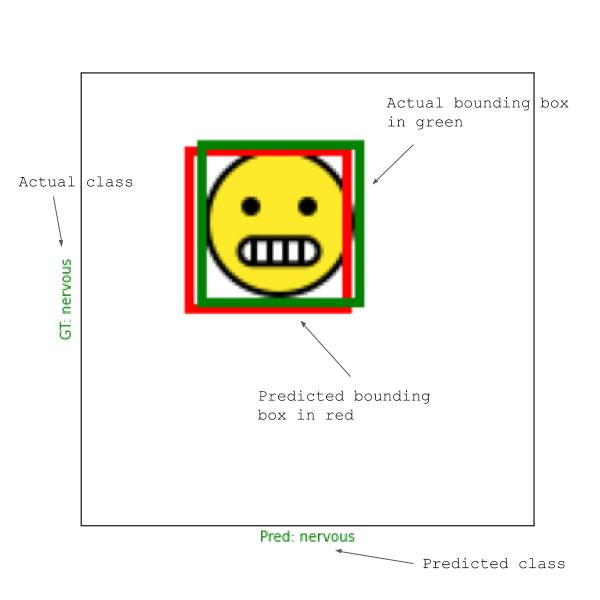

All emojis designed by [OpenMoji](https://openmoji.org/) – the open-source emoji and icon project. License: CC BY-SA 4.0

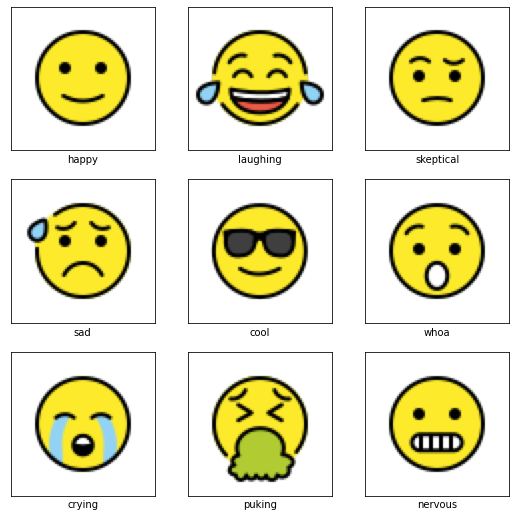

In [6]:
# Display the emojis which will be used for this code.
# We won't be using these emojis as is, but we will be
# placing them in larger images because they will help
# us in synthesizing data for object localization-
plt.figure(figsize = (9, 9))

for i, (j, e) in enumerate(emojis.items()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(plt.imread(os.path.join('emojis', e['file'])))
    plt.xlabel(e['name'])
    plt.xticks([])
    plt.yticks([])
plt.show()

### Create Examples

In [7]:
for class_id, values in emojis.items():
    png_file = Image.open(os.path.join('emojis', values['file'])).convert('RGBA')
    png_file.load()
    new_file = Image.new("RGB", png_file.size, (255, 255, 255))
    new_file.paste(png_file, mask = png_file.split()[3])
    emojis[class_id]['image'] = new_file

In [8]:
# Sanity check-
emojis.keys()

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [9]:
emojis[3].keys()

dict_keys(['name', 'file', 'image'])

In [10]:
# All images get added to 'emojis' Python3 dict-
[emojis[i]['name'] for i in emojis.keys()]

['happy',
 'laughing',
 'skeptical',
 'sad',
 'cool',
 'whoa',
 'crying',
 'puking',
 'nervous']

In [11]:
def create_example():
    '''
    Function to randomly choose an emoji class and synthesize an image for that
    emoji class. Emoji images are of dimensions- (72, 72, 3)
    '''
    
    # Since the image class ids range from 0 to 8-
    class_id = np.random.randint(0, 9)
    
    # Create a blank image of size (144, 144, 3) multiplied with 255 as starting values
    # for each pixels-
    image = np.ones((144, 144, 3)) * 255
    # creates a blank white image.
    
    # Randomly decide the position where the emoji should be localized.
    # Since emoji size is (72, 72) and the blank image is of size (144, 144),
    # row and col are coded as-
    row = np.random.randint(0, 72)
    col = np.random.randint(0, 72)
    
    # print(f"row value = {row} & col value = {col}")
    
    # Place the emoji in the blank image created above. Place the emoji between
    # 'row' & 'row + 72' and 'col' & 'col + 72'. Use 'np.array()' to convert the
    # PIL image into np array-
    image[row: row + 72, col: col + 72, :] = np.array(emojis[class_id]['image'])
    
    # Return the emoji position. We are not scaling the emoji. To return the emoji
    # position, we can just return 'row' & 'col' values, but these values are offset
    # by using a buffer of 10 pixels. And the reason for this buffer is because we
    # have approximately 10 pixels on each side of the emoji which are unutilized,
    # so we can crop the emojis out, in a way. Finally, these values are normalized.
    return image.astype('uint8'), class_id, (row + 10) / 144, (col + 10) / 144


class_id = 0, emoji name = happy, row = 0.18 & col = 0.50
unnormalized row value = 26.0 & col value = 72.0


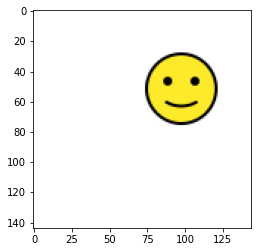

In [12]:
image, class_id, row, col = create_example()
plt.imshow(image)

print(f"class_id = {class_id}, emoji name = {emojis[class_id]['name']}, row = {row:.2f} & col = {col:.2f}")
print(f"unnormalized row value = {row * 144} & col value = {col * 144}")

### Plot Bounding Boxes - required for _object localization_

In [13]:
def plot_bounding_box(image, gt_coords, pred_coords = [], norm = False):
    '''
    Python3 function to plot bounding box for a given image and location.
    
    Inputs:
        1.) gt_coords - ground truth co-ordinates
        2.) pred_coords - predicted co-ordinates
        3.) norm - (binary value as flag) image values are normalized or not
    '''
    if norm:
        # denormalize the image values by scaling them up-
        image *= 255.
        
        # convert image type-
        image = image.astype('uint8')
    
    # convert from np array to PIL image-
    image = Image.fromarray(image)
    
    # Create a 'Draw' instance using the created image-
    draw = ImageDraw.Draw(image)

    # Extract row and col values from our groud truth co-oridinates-
    row, col = gt_coords
    
    # Scale back the row and col values-
    row *= 144
    col *= 144
    
    # Use 'Draw' instance to create a rectangle
    # The values need to be x1, y1, x2 & y2 where x1 & y1 are the
    # co-ordinates for the top left point of the rectangle and
    # x2 & y2 are the co-ordinates for the bottom right point of the
    # rectangle/bounding box.
    # Hence, x1 = col, y1 = row, x2 = col + 52 & y2 = row + 52.
    # Note that since the emojis are of size 72 x 72 and due to having
    # a buffer of 10 pixels on each side, we can crop out 72 - 20 = 52.
    # Hence using 52 instead of 72 results into a more tight bounding box.
    draw.rectangle((col, row, col + 52, row + 52), outline = 'green', width = 3)

    
    # Perform the same steps for our predicted (bounding box) co-ordinates-
    if len(pred_coords) == 2:
        row, col = pred_coords
        row *= 144
        col *= 144
        draw.rectangle((col, row, col + 52, row + 52), outline = 'red', width = 3)
        
    return image


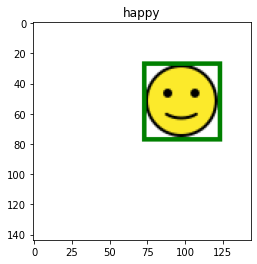

In [14]:
# Sanity check-
image = plot_bounding_box(image, gt_coords = [row, col])

plt.imshow(image)
plt.title(emojis[class_id]['name'])
plt.show()

### Data Generator

Create an endless stream of such randomly generated examples which will be used to train our _object localization_ model.

In [15]:
def data_generator(batch_size = 16):
    '''
    Python3 function to create an endless stream of training examples
    for our object localisation model.
    '''
    
    while True:
        # For each iteration, we create examples and labels-
        x_batch = np.zeros((batch_size, 144, 144, 3))
        
        # The label is not just the class label but also the co-ordinates-
        y_batch = np.zeros((batch_size, 9)) # we have 9 classes which are one-hot encoded
        bbox_batch = np.zeros((batch_size, 2)) # boundix box or co-ordinates - 2 for row & column values
        
        # print(f"x_batch.shape = {x_batch.shape}, y_batch.shape = {y_batch.shape} & bbox_batch = {bbox_batch}")
    
        # Create such examples as above equal to batch size number of examples-
        for i in range(0, batch_size):
            image, class_id, row, col = create_example()
            x_batch[i] = image / 255.0  # pixel values are between 0 - 255
            y_batch[i, class_id] = 1.0
            bbox_batch[i] = np.array([row, col])
    
        yield {'image': x_batch}, {'class_out': y_batch, 'box_out': bbox_batch}


image.shape = (144, 144, 3) & type(image) = <class 'numpy.ndarray'>
image.min = 0.0 & image.max = 1.0

class_id = 8

bounding box coordinates are: [0.375      0.20138889]



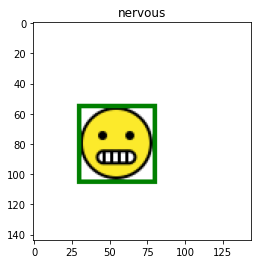

In [16]:
# 'example' & 'label' are Python3 dict-
example, label = next(data_generator(batch_size = 1))

image = example['image'][0]
print(f"image.shape = {image.shape} & type(image) = {type(image)}")
print(f"image.min = {image.min()} & image.max = {image.max()}")

class_id = np.argmax(label['class_out'][0])
print(f"\nclass_id = {class_id}")

coordinates = label['box_out'][0]
print(f"\nbounding box coordinates are: {coordinates}\n")


image_bbox = plot_bounding_box(image = image, gt_coords = coordinates, norm = True)
plt.imshow(image_bbox)
plt.title(emojis[class_id]['name'])
plt.show()

### Define CNN Model

In [ ]:
class CNN_Localization(Model):
    def __init__(self):
        super(CNN_Localization, self).__init__()
        
        self.conv1 = Conv2D(
            filters = 32, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None, use_bias = False,
        )
        self.bn1 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
        )
        self.conv2 = Conv2D(
            filters = 32, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None, use_bias = False,
        )
        self.bn2 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
        )
        self.pool1 = MaxPool2D(pool_size = (2, 2))
        
        self.conv3 = Conv2D(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None, use_bias = False,
        )
        self.bn3 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
        )
        self.conv4 = Conv2D(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None, use_bias = False,
        )
        self.bn4 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
        )
        self.pool2 = MaxPool2D(pool_size = (2, 2))
        
        self.conv5 = Conv2D(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None, use_bias = False,
        )
        self.bn5 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
        )
        self.conv6 = Conv2D(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None, use_bias = False,
        )
        self.bn6 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
        )
        self.pool3 = MaxPool2D(pool_size = (2, 2))
        
        self.conv7 = Conv2D(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None, use_bias = False,
        )
        self.bn7 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
        )
        self.conv8 = Conv2D(
            filters = 64, kernel_size = 3,
            strides = 1, padding = 'same',
            activation = None, use_bias = False,
        )
        self.bn8 = BatchNormalization(
            axis = -1, momentum = 0.99,
            epsilon = 0.001
        )
        self.pool4 = MaxPool2D(pool_size = (2, 2))
        
        self.flatten = Flatten()
        # self.classification_layer = Dense(units = 9, activation = None, name = 'class_out')
        # self.bounding_box_layer = Dense(units = 2, activation = None, name = 'box_out')
        self.class_out = Dense(units = 9, activation = 'softmax', name = 'class_out')
        self.box_out = Dense(units = 2, activation = 'linear', name = 'box_out')



    
    
    def call(self, x):
        x = tf.nn.relu(self.bn1(self.conv1(x)))
        x = tf.nn.relu(self.bn2(self.conv2(x)))
        x = self.pool1(x)
        x = tf.nn.relu(self.bn3(self.conv3(x)))
        x = tf.nn.relu(self.bn4(self.conv4(x)))
        x = self.pool2(x)
        x = tf.nn.relu(self.bn5(self.conv5(x)))
        x = tf.nn.relu(self.bn6(self.conv6(x)))
        x = self.pool3(x)
        x = tf.nn.relu(self.bn7(self.conv7(x)))
        x = tf.nn.relu(self.bn8(self.conv8(x)))
        x = self.pool4(x)
        
        x = self.flatten(x)
        
        # Use a list for 2 outputs-
        x = [tf.nn.relu(self.class_out(x)), self.box_out(x)]
        return x
        
        

In [17]:
# Using Keras's functional API to construct the desired model-

input_ = Input(shape = (144, 144, 3), name = 'image')
# name - An optional name string for the Input layer. Should be unique in
# a model (do not reuse the same name twice). It will be autogenerated if it isn't provided.

# Here 'image' is the Python3 dict's key used to map the data to one of the layer in the model.

x = input_

# Define 5 conv blocks-
for i in range(0, 5):
    n_filters = 2 ** (4 + i)
    x = Conv2D(filters = n_filters, kernel_size = 3, activation = 'relu')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(pool_size = 2)(x)

x = Flatten()(x)  # flatten the last pooling layer's output volume
x = Dense(256, activation='relu')(x)
# Connect the dense/FC layer above to two outputs

# We are using a data generator which yields dictionaries. Using 'name' argument makes it
# possible to map the correct data generator's output to the appropriate layer
class_out = Dense(units = 9, activation = 'softmax', name = 'class_out')(x)  # classification output
box_out = Dense(units = 2, activation = 'linear', name = 'box_out')(x)  # regression output


# Define the CNN model-
model = tf.keras.models.Model(input_, [class_out, box_out])  # since we have 2 outputs, we use a list


2022-06-27 17:35:18.354726: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-27 17:35:18.356468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 17:35:18.356721: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-27 17:35:18.356900: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [ ]:
# Initialize a CNN for localization-
# model = CNN_Localization()

In [18]:
# Sanity check-
example, label = next(data_generator(batch_size = 32))

In [19]:
image = example['image']

In [20]:
image.shape

(32, 144, 144, 3)

In [21]:
out = model(image)

2022-06-27 17:35:23.865797: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8400
2022-06-27 17:35:24.588524: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


In [22]:
out[0].shape, out[1].shape

(TensorShape([32, 9]), TensorShape([32, 2]))

In [23]:
del out, example, label

In [24]:
model.summary()
# Observe that the two outputs are connected to the same input, viz., 'dense[0][0]'

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 144, 144, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 142, 142, 16  448         ['image[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 142, 142, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

### Custom Metric: Intersection over Union (IoU)

IoU is an evaluation metric used to measure the performance of our model during training. This metric is used to find the accuracy of object detection model/algorithm. IoU is the area of overlap between the actual and predicted boxes. To get this, you combine both of the areas and then subtracting the intersection. This gives the IoU.

IoU = area of intersection / area of union

In [25]:
class IoU(tf.keras.metrics.Metric):
    def __init__(self, **kwargs):
        super(IoU, self).__init__(**kwargs)

        self.iou = self.add_weight(name = 'iou', initializer = 'zeros')
        self.total_iou = self.add_weight(name = 'total_iou', initializer = 'zeros')
        self.num_ex = self.add_weight(name = 'num_ex', initializer = 'zeros')
        # total number of examples we have gone through
        
  
    def update_state(self, y_true, y_pred, sample_weight = None):
        '''
        Each 'y' value has row and column. Rows are at index 0 and the columns are
        at index 1.
        '''
        def get_box(y):
            rows, cols = y[:, 0], y[:, 1]
            rows, cols = rows * 144, cols * 144  # scale the values
            # We are trying to find out the bounding box using the row & column values.
            
            # Each box is of fixed size (52, 52)-
            y1, y2 = rows, rows + 52
            x1, x2 = cols, cols + 52
            
            return x1, y1, x2, y2
    
        def get_area(x1, y1, x2, y2):
            return tf.math.abs(x2 - x1) * tf.math.abs(y2 - y1)
    
        # Ground truth co-ordinates-
        gt_x1, gt_y1, gt_x2, gt_y2 = get_box(y_true)
        
        # Predicted co-ordinates-
        p_x1, p_y1, p_x2, p_y2 = get_box(y_pred)
        
        # To compute intersection co-ordinates-
        i_x1 = tf.maximum(gt_x1, p_x1)
        i_y1 = tf.maximum(gt_y1, p_y1)
        i_x2 = tf.minimum(gt_x2, p_x2)
        i_y2 = tf.minimum(gt_y2, p_y2)

        i_area = get_area(i_x1, i_y1, i_x2, i_y2)
        u_area = get_area(gt_x1, gt_y1, gt_x2, gt_y2) + get_area(p_x1, p_y1, p_x2, p_y2) - i_area

        iou = tf.math.divide(i_area, u_area)
        self.num_ex.assign_add(1)
        self.total_iou.assign_add(tf.reduce_mean(iou))
        self.iou = tf.math.divide(self.total_iou, self.num_ex)
  
    def result(self):
        return self.iou
  
    def reset_state(self):
        self.iou = self.add_weight(name = 'iou', initializer = 'zeros')
        self.total_iou = self.add_weight(name = 'total_iou', initializer = 'zeros')
        self.num_ex = self.add_weight(name = 'num_ex', initializer = 'zeros')

        

In [26]:
# Compile defined model-
model.compile(
    loss = {
        'class_out': tf.keras.losses.CategoricalCrossentropy(),
        # 'class_out': 'categorical_crossentropy',
        'box_out': tf.keras.losses.MeanSquaredError()
        # 'box_out': 'mse'
    },
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-3),
    metrics = {
        'class_out': 'accuracy',
        'box_out': IoU(name = 'iou')
    }
)

### Custom Callback: Model Testing

In [27]:
def test_model(model, test_datagen):
    example, label = next(test_datagen)
    x = example['image']
    y = label['class_out']
    box = label['box_out']

    pred_y, pred_box = model.predict(x)

    pred_coords = pred_box[0]
    gt_coords = box[0]
    pred_class = np.argmax(pred_y[0])
    image = x[0]

    gt = emojis[np.argmax(y[0])]['name']
    pred_class_name = emojis[pred_class]['name']

    image = plot_bounding_box(image, gt_coords, pred_coords, norm=True)
    color = 'green' if gt == pred_class_name else 'red'

    plt.imshow(image)
    plt.xlabel(f'Pred: {pred_class_name}', color = color)
    plt.ylabel(f'GT: {gt}', color = color)
    plt.xticks([])
    plt.yticks([])
    

In [28]:
def test(model):
    test_datagen = data_generator(1)

    plt.figure(figsize = (16, 4))

    for i in range(0, 6):
        plt.subplot(1, 6, i + 1)
        test_model(model, test_datagen)
    plt.show()
   

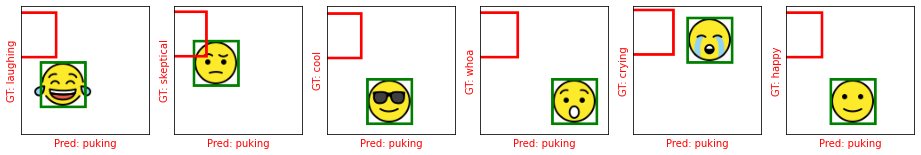

In [29]:
test(model)

In [30]:
class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = None):
        test(self.model)
        

In [31]:
def lr_schedule(epoch, lr):
    if (epoch + 1) % 5 == 0:
        lr *= 0.2
    
    return max(lr, 3e-7)


### [Intersection over Union (IoU) for object detection](https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/)

_An Intersection over Union score > 0.5 is normally considered a “good” prediction_.

In [33]:
# Train model-
history = model.fit(
    data_generator(), epochs = 50,
    steps_per_epoch = 196, batch_size = 256,
    callbacks = [
        # ShowTestImages(),
        tf.keras.callbacks.EarlyStopping(
            monitor = 'box_out_iou', patience = 3,
            mode = 'max', restore_best_weights = True
        ),
        # tf.keras.callbacks.LearningRateScheduler(lr_schedule)
    ]
)

Epoch 1/50
196/196 [==============================] - 2s 6ms/step - loss: 2.1267 - class_out_loss: 1.6407 - box_out_loss: 0.4860 - class_out_accuracy: 0.4378 - box_out_iou: 0.2135
Epoch 2/50
196/196 [==============================] - 1s 6ms/step - loss: 0.2594 - class_out_loss: 0.1658 - box_out_loss: 0.0936 - class_out_accuracy: 0.9601 - box_out_iou: 0.2093
Epoch 3/50
196/196 [==============================] - 1s 6ms/step - loss: 0.0895 - class_out_loss: 0.0371 - box_out_loss: 0.0525 - class_out_accuracy: 0.9949 - box_out_iou: 0.2148
Epoch 4/50
196/196 [==============================] - 1s 6ms/step - loss: 0.0572 - class_out_loss: 0.0225 - box_out_loss: 0.0347 - class_out_accuracy: 0.9971 - box_out_iou: 0.2290
Epoch 5/50
196/196 [==============================] - 1s 6ms/step - loss: 0.0309 - class_out_loss: 0.0067 - box_out_loss: 0.0242 - class_out_accuracy: 0.9994 - box_out_iou: 0.2484
Epoch 6/50
196/196 [==============================] - 1s 6ms/step - loss: 0.0199 - class_out_loss: 0

In [34]:
# Save trained model-
model.save_weights("CNN_trained_emoji.h5", overwrite = True)

In [35]:
history.history.keys()

dict_keys(['loss', 'class_out_loss', 'box_out_loss', 'class_out_accuracy', 'box_out_iou'])

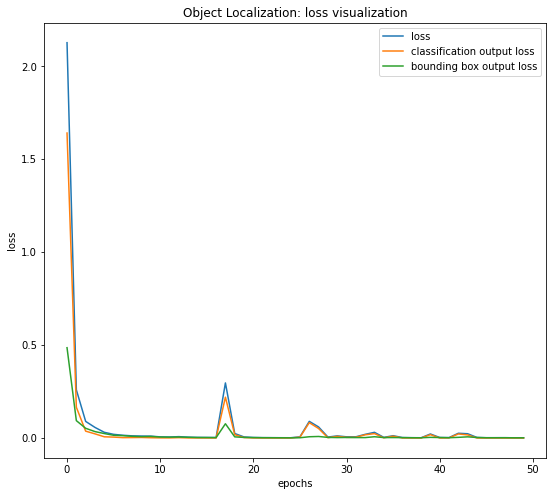

In [38]:
plt.figure(figsize = (9, 8))
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['class_out_loss'], label = 'classification output loss')
plt.plot(history.history['box_out_loss'], label = 'bounding box output loss')
plt.title("Object Localization: loss visualization")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

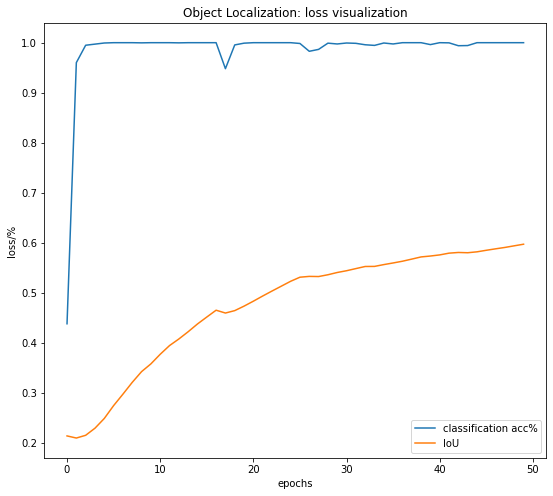

In [39]:
plt.figure(figsize = (9, 8))
plt.plot(history.history['class_out_accuracy'], label = 'classification acc%')
plt.plot(history.history['box_out_iou'], label = 'IoU')
plt.title("Object Localization: loss visualization")
plt.legend(loc = 'best')
plt.xlabel("epochs")
plt.ylabel("loss/%")
plt.show()

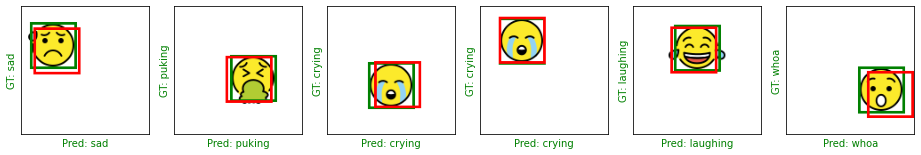

In [40]:
# Use trained model for testing-
test(model)

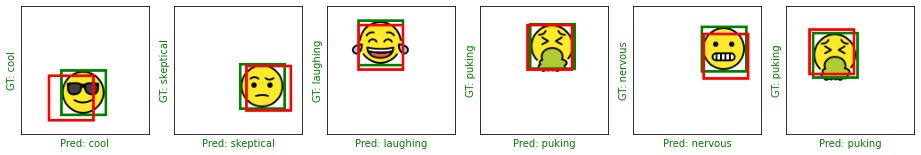

In [41]:
test(model = model)